## Task B: Image segmentation of Butterfly

In [1]:
#!git clone https://github.com/EmdaloTechnologies/CE6003.git

In [2]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Debug Environment
import platform
import sys

print("System", platform.system(), "-", platform.release())
print("Executable", sys.executable)
print("Python", platform.python_version())
print("OpenCV", cv2.__version__)

System Windows - 10
Executable C:\Users\abhijits\AppData\Local\Continuum\anaconda3.7\python.exe
Python 3.7.5
OpenCV 4.1.1


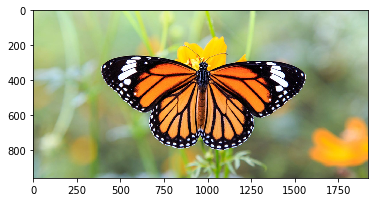

In [4]:
# Load a color image
img = cv2.imread("./images/lab2/butterfly.jpg")

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

First, lets use OpenCV's fastN1MeansDenoisingColored routine to denoise the image.  We're using a larger 'h' and 'hColor' value than typically used as the image is more noisy than images typically used with these technique.  (This should make more sense as we go forward into the CNN segmentation examples).

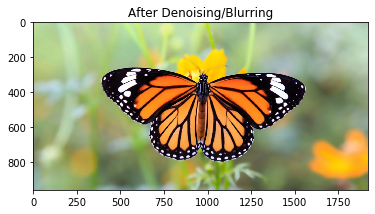

In [5]:
# Apply some blurring to reduce noise

# h is the Parameter regulating filter strength for luminance component. 
# Bigger h value perfectly removes noise but also removes image details, 
# smaller h value preserves details but also preserves some noise
h = 25
hColor = 15

# Default values
templateWindowSize = 7
searchWindowSize = 21

blur = cv2.fastNlMeansDenoisingColored(img, None, h, hColor,templateWindowSize,searchWindowSize)

plt.title("After Denoising/Blurring")
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB));

Now, lets run a morphological operation on the blurred image.  

For this example, we are going to generate a gradient.  

This builds on dilation and erosion.  You can read more about erosion and dilation 
in the 'Basics' section of Lesson 2.

Today we are going to use them to generate an outline for our starfish.


# Edge Detection
Instead of using a gradient, you could use an edge detection such as Sobel, Laplacian and Canny here in combination with adjusting the image denoising step above.  I'll leave those as an exercise for the reader for now!

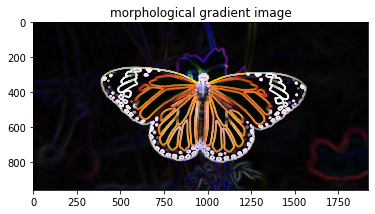

In [6]:
# Apply a morphological gradient (dilate the image, erode the image, and take the difference
elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))

# Use openCV's morphologyEx to generate a gradient using the kernel above
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)

plt.title("morphological gradient image")
plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))
plt.show()

We now have completed the pre-processing of our image. 

From this point onwards, we are concerning ourselves with:

a) filling the region of interest, and

b) removing artefacts from the image which we are not interested in.

There are quite a few approaches we can take to this (including not doing them at all), but today lets apply OTSU's threshold to convert the image to black and white, and perform a closing operation to 'fill in' the starfish and then perform some erosion to remove parts of the image that we consider noise.

## OTSU Thresholding
When converting from a grayscale image to a black and white image, selecting a good threshold value can be a time-consuming and manual process.  There are a number of automatic thresholding techniques available - and Otsu's method thresholding is one of the better known techniques.

Conceptually simple, and relatively low cost computationally, Otsu's threshold iterate through all the possible threshold values to find the threshold value where the sum of foreground and background spreads is at its minimum. 


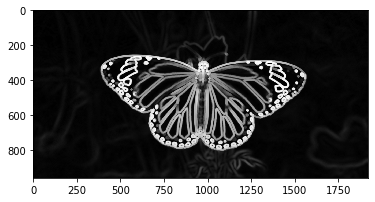

In [7]:
# Apply Otsu's method - or you can adjust the level at which thresholding occurs
# and see what the effect of this is

# Convert gradient to grayscale
gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)
plt.imshow(gradient, cmap='gray');

The OTSU threshold is 87.0


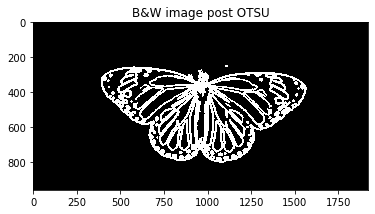

In [8]:
# Otsu's method: determines an optimal global threshold value from the image histogram.
# https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

otsu_th, otsu_image = cv2.threshold(gradient, 0, 255, cv2.THRESH_OTSU)
print(f"The OTSU threshold is {otsu_th}")

plt.title("B&W image post OTSU")
plt.imshow(otsu_image, cmap='gray');

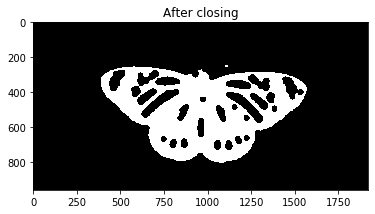

In [9]:
# Apply a closing operation - we're using a large kernel here. By all means adjust the size of this kernel
# and observe the effects
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33,33))
close = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE, closingKernel)

plt.title("After closing")
plt.imshow(close, cmap='gray');

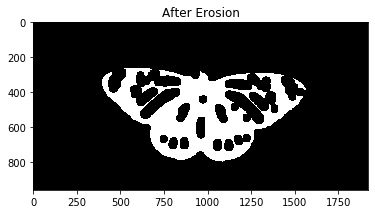

In [10]:
# Erode smaller artefacts out of the image - play with iterations to see how it works
erosionKernel = np.ones((5,5),np.uint8)
eroded = cv2.erode(close, erosionKernel, iterations = 3)

plt.title("After Erosion")
plt.imshow(eroded, cmap='gray');

## Obsevarion: Erosion is removing the boundary edge pixels and this can lead to a weak countour.
## Decision made is to avoid erosion in this case.

So, now we've effectively segmented our image. 

Now, let's post-process the image to find the contours that represent the edge of the starfish.  We'll just use the intuition that the starfish is the largest object in the scene.

Then we'lll do a little image manipulation to generate a colour representing the starfish, another colour representing the background (i.e. not the starfish) and then merge those colours with the original image.

You'll notice the closing and erosion steps are not perfect - they're not supposed to be.  They are good enough to feed into the findContours routine.  By all means, tune them further to get better quality input into findContours.

In the findContours routine we're using cv2.RETR_EXTERNAL.  This is to reduce the complexity of post-processing by only reporting 'external' contours (i.e. we'll attempt to suppress contours that are inside other contours).

In [11]:
p = int(img.shape[1] * 0.05)
eroded[:, 0:p] = 0
eroded[:, img.shape[1] - p:] = 0

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html

Number of Contours found 28


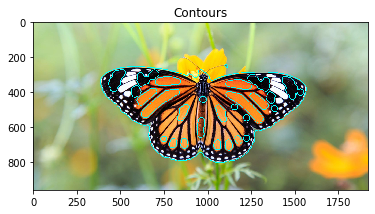

In [12]:
# Find the contours on the image after closing- just external contours to keep post-processing simple
contours, hierarchy = cv2.findContours(close,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
print(f"Number of Contours found {len(contours)}") 

# Draw all contours 
# -1 signifies drawing all contours (in red color 255 0 0 )
contour_img=img.copy()
cv2.drawContours(contour_img, contours, -1, (255, 255, 0), 3) 

plt.title("Contours")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB));

(960, 1920, 3)


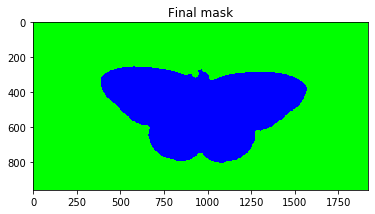

In [13]:
# Sort the candidates by size, and just keep the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Lets create two images, initially all zeros (i.e. black)
# One image will be filled with 'Blue' wherever we think there's some starfish
# The other image will be filled with 'Green' whereever we think there's not some starfish
h, w, num_c = img.shape
print(img.shape)

segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

# I know we've only one contour, but - in general - we'd expect to have more contours to deal with
for c in contours:
    # Fill in the starfish shape into segmask
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    # Lets fill in the starfish shape into stencil as well
    # and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]

# Now, lets create a mask image by bitwise ORring segmask and stencil together
mask = cv2.bitwise_or(stencil, segmask)

plt.title("Final mask")
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB));

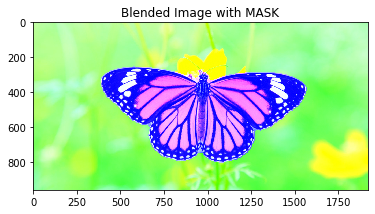

In [14]:
# Now, lets just blend our original image with our mask
# apply mask to the original image
output = cv2.bitwise_or(mask, img)
plt.title("Blended Image with MASK")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB));

### Plotting all the image processing steps

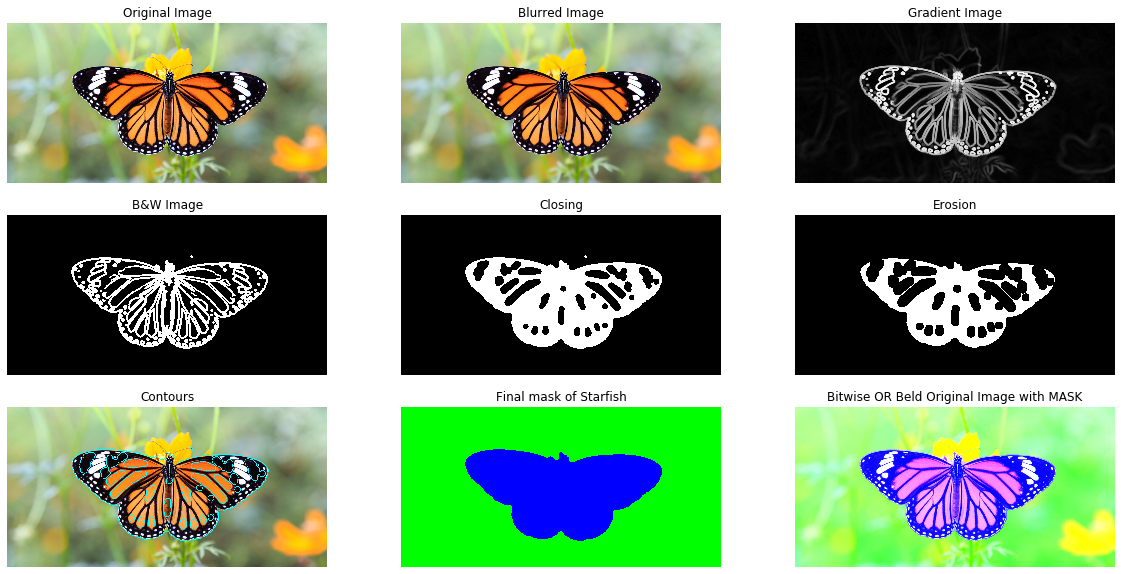

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(3,3,1), plt.axis("off"), plt.title("Original Image"), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(3,3,2), plt.axis("off"), plt.title("Blurred Image"), plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.subplot(3,3,3), plt.axis("off"), plt.title("Gradient Image"), plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))
plt.subplot(3,3,4), plt.axis("off"), plt.title("B&W Image"), plt.imshow(otsu_image, cmap='gray')
plt.subplot(3,3,5), plt.axis("off"), plt.title("Closing"), plt.imshow(close, cmap='gray')
plt.subplot(3,3,6), plt.axis("off"), plt.title("Erosion"), plt.imshow(eroded, cmap='gray')
plt.subplot(3,3,7), plt.axis("off"), plt.title("Contours"), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.subplot(3,3,8), plt.axis("off"), plt.title("Final mask of Starfish"), plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.subplot(3,3,9), plt.axis("off"), plt.title("Bitwise OR Beld Original Image with MASK"), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()


# Conclusion

So, that completes the first of the four labs to this module.  

To summarise , we''ve learned some basic image processing techniques, such as morphological operations like erosion and dilation, contour detection and we've used these techniques in combination with Otsu's thresholding method to segment an image.
